# Cluster splitting

# table of content
1) 

### Dependencies and general utils

In [ ]:
# pip install scipy

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
# import pdal
import json
import scipy
import copy
import pickle
from tqdm import tqdm
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from sklearn.decomposition import PCA

### function implementation

In [6]:
def transform_with_pca(pointcloud, verbose=False):
    # 1. Fit PCA
    pca = PCA(n_components=2)
    transformed = pca.fit_transform(pointcloud)

    # You can access components and mean
    components = pca.components_  # principal axes
    mean = pca.mean_
    if verbose:
        print("PCA components (axes):\n", components)
        print("PCA-transformed points:\n", transformed)
    
    return transformed
    

### test with numpy arrays

In [7]:
points = np.array([
    [2.5, 2.4],
    [0.5, 0.7],
    [2.2, 2.9],
    [1.9, 2.2],
    [3.1, 3.0],
    [2.3, 2.7],
    [2.0, 1.6],
    [1.0, 1.1],
    [1.5, 1.6],
    [1.1, 0.9],
])
points_transformed = transform_with_pca(points, True)
print(np.std(points_transformed[:,0]))
print(np.std(points_transformed[:,1]))

PCA components (axes):
 [[ 0.6778734   0.73517866]
 [ 0.73517866 -0.6778734 ]]
PCA-transformed points:
 [[ 0.82797019  0.17511531]
 [-1.77758033 -0.14285723]
 [ 0.99219749 -0.38437499]
 [ 0.27421042 -0.13041721]
 [ 1.67580142  0.20949846]
 [ 0.9129491  -0.17528244]
 [-0.09910944  0.3498247 ]
 [-1.14457216 -0.04641726]
 [-0.43804614 -0.01776463]
 [-1.22382056  0.16267529]]
1.0749999725374437
0.21017863603252968


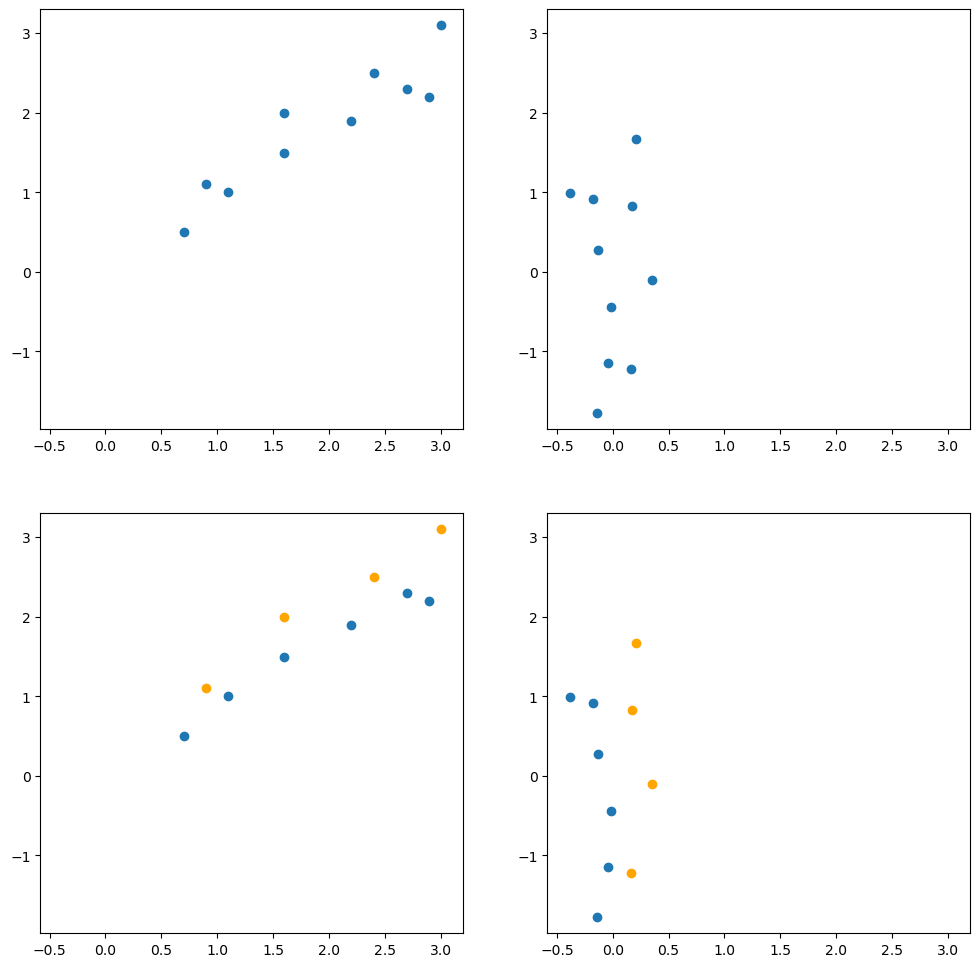

In [27]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()
axs[0].scatter(points[:,1], points[:,0])
axs[1].scatter(points_transformed[:,1], points_transformed[:,0])
x_min = np.min(np.concatenate([points[:,1],points_transformed[:,1]]))
x_max = np.max(np.concatenate([points[:,1],points_transformed[:,1]]))
y_min = np.min(np.concatenate([points[:,0],points_transformed[:,0]]))
y_max = np.max(np.concatenate([points[:,0],points_transformed[:,0]]))

for ax in axs:
    ax.set_xlim([x_min-0.2, x_max+0.2])
    ax.set_ylim([y_min-0.2, y_max+0.2])

# cut
mask_pos = points_transformed[:,1] > 0
mask_neg = mask_pos == False

axs[2].scatter(points[:,1][mask_pos], points[:,0][mask_pos], color='orange')
axs[2].scatter(points[:,1][mask_neg], points[:,0][mask_neg])
axs[3].scatter(points_transformed[:,1][mask_pos], points_transformed[:,0][mask_pos], color='orange')
axs[3].scatter(points_transformed[:,1][mask_neg], points_transformed[:,0][mask_neg])

### Tests with two overlapping pointclouds

In [64]:
# overlapping pointclouds

np.random.seed(42)  # for reproducibility

# Overlapping region (centered at (0, 0))
overlap_points = np.random.normal(loc=0.0, scale=[0.5, 1], size=(30, 2))

#rotate overlapping
angle = np.pi/4
M = [[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]]
overlap_points = (M @ overlap_points.T).T

# Unique part of A (shifted left)
unique_A = np.random.normal(loc=-3.0, scale=1, size=(100, 2))

# Unique part of B (shifted right)
unique_B = np.random.normal(loc=3.0, scale=1, size=(100, 2))

# Full sets
# A = unique_A
# B = unique_B
A = np.vstack([overlap_points, unique_A])
B = np.vstack([overlap_points, unique_B])


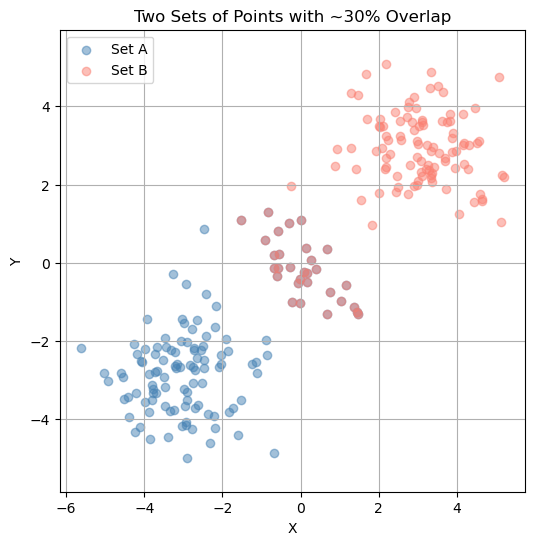

In [69]:
plt.figure(figsize=(6, 6))
plt.scatter(A[:, 0], A[:, 1], color='steelblue', label='Set A', alpha=0.5)
plt.scatter(B[:, 0], B[:, 1], color='salmon', label='Set B', alpha=0.5)
plt.legend()
plt.title("Two Sets of Points with ~30% Overlap")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis('equal')
plt.show()

Text(0.5, 1.0, '4) Corresponding split in original coords')

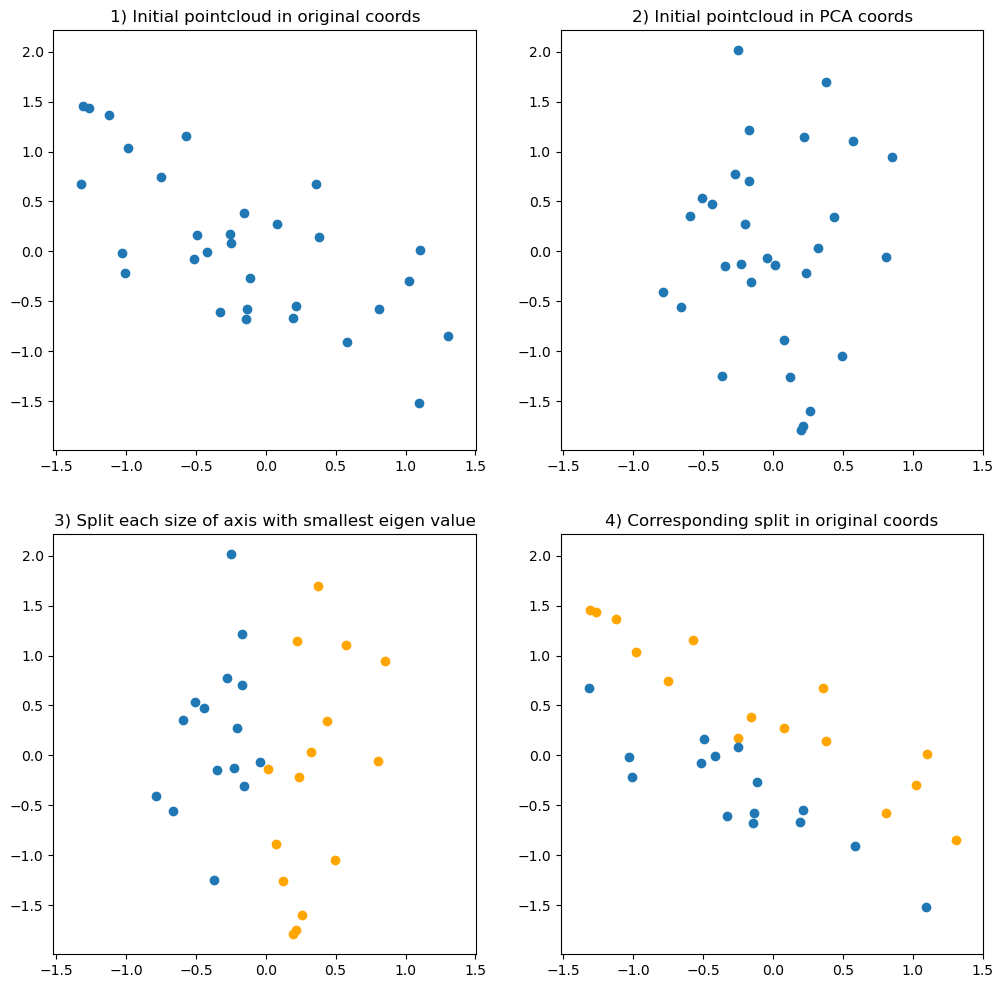

In [111]:
# find overlapping region
points = overlap_points
points_transformed = transform_with_pca(points)
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()
axs[0].scatter(points[:,1], points[:,0])
axs[1].scatter(points_transformed[:,1], points_transformed[:,0])
x_min = np.min(np.concatenate([points[:,1],points_transformed[:,1]]))
x_max = np.max(np.concatenate([points[:,1],points_transformed[:,1]]))
y_min = np.min(np.concatenate([points[:,0],points_transformed[:,0]]))
y_max = np.max(np.concatenate([points[:,0],points_transformed[:,0]]))

for ax in axs:
    ax.set_xlim([x_min-0.2, x_max+0.2])
    ax.set_ylim([y_min-0.2, y_max+0.2])

# cut
mask_pos = points_transformed[:,1] > 0
mask_neg = mask_pos == False

axs[2].scatter(points_transformed[:,1][mask_pos], points_transformed[:,0][mask_pos], color='orange')
axs[2].scatter(points_transformed[:,1][mask_neg], points_transformed[:,0][mask_neg])
axs[3].scatter(points[:,1][mask_pos], points[:,0][mask_pos], color='orange')
axs[3].scatter(points[:,1][mask_neg], points[:,0][mask_neg])

axs[0].set_title("1) Initial pointcloud in original coords")
axs[1].set_title("2) Initial pointcloud in PCA coords")
axs[2].set_title("3) Split each size of axis with smallest eigen value")
axs[3].set_title("4) Corresponding split in original coords")

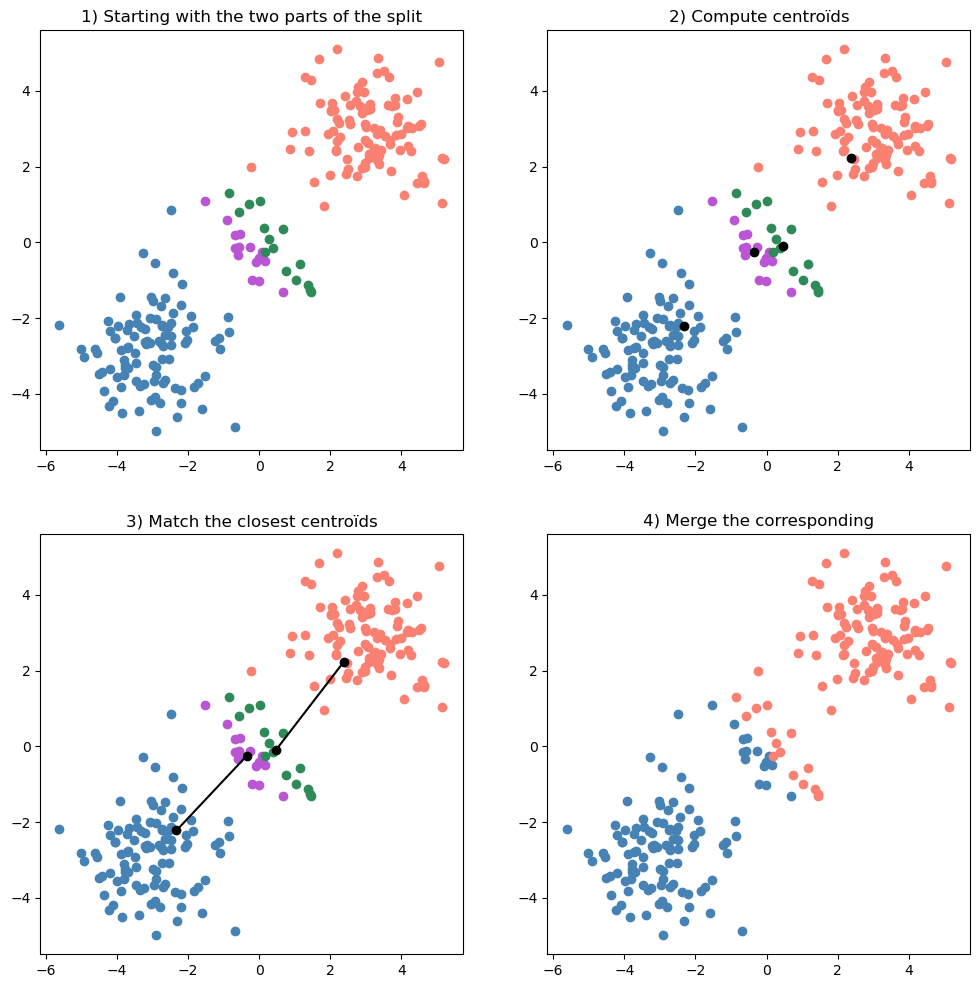

In [116]:
# find centroids of the two clusters:
centroid_A = np.mean(A, axis=0)
centroid_B = np.mean(B, axis=0)

centroid_pos = np.mean(points[mask_pos], axis=0)
centroid_neg = np.mean(points[mask_neg], axis=0)

dist_pos_A = ((centroid_A[0] - centroid_pos[0])**2 + (centroid_A[1] - centroid_pos[1])**2)**0.5
dist_pos_B = ((centroid_B[0] - centroid_pos[0])**2 + (centroid_B[1] - centroid_pos[1])**2)**0.5

if dist_pos_A < dist_pos_B:
    A_final = np.vstack([unique_A, overlap_points[mask_pos]])
    B_final = np.vstack([unique_B, overlap_points[mask_neg]])
else:
    A_final = np.vstack([unique_A, overlap_points[mask_neg]])
    B_final = np.vstack([unique_B, overlap_points[mask_pos]])


fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()
axs[0].scatter(unique_A[:,0], unique_A[:,1], color='steelblue')
axs[0].scatter(unique_B[:,0], unique_B[:,1], color='salmon')
axs[0].scatter(overlap_points[:,0][mask_neg], overlap_points[:,1][mask_neg], color='mediumorchid')
axs[0].scatter(overlap_points[:,0][mask_pos], overlap_points[:,1][mask_pos], color='seagreen')

axs[1].set_title("Starting with the two parts of the overlapping clusters")
axs[1].scatter(unique_A[:,0], unique_A[:,1], color='steelblue')
axs[1].scatter(unique_B[:,0], unique_B[:,1], color='salmon')
axs[1].scatter(overlap_points[:,0][mask_neg], overlap_points[:,1][mask_neg], color='mediumorchid')
axs[1].scatter(overlap_points[:,0][mask_pos], overlap_points[:,1][mask_pos], color='seagreen')
axs[1].scatter(centroid_A[0], centroid_A[1], color='black')
axs[1].scatter(centroid_B[0], centroid_B[1], color='black')
axs[1].scatter(centroid_pos[0], centroid_pos[1], color='black')
axs[1].scatter(centroid_neg[0], centroid_neg[1], color='black')

axs[2].scatter(unique_A[:,0], unique_A[:,1], color='steelblue')
axs[2].scatter(unique_B[:,0], unique_B[:,1], color='salmon')
axs[2].scatter(overlap_points[:,0][mask_neg], overlap_points[:,1][mask_neg], color='mediumorchid')
axs[2].scatter(overlap_points[:,0][mask_pos], overlap_points[:,1][mask_pos], color='seagreen')
axs[2].scatter(centroid_A[0], centroid_A[1], color='black')
axs[2].scatter(centroid_B[0], centroid_B[1], color='black')
axs[2].scatter(centroid_pos[0], centroid_pos[1], color='black')
axs[2].scatter(centroid_neg[0], centroid_neg[1], color='black')
axs[2].plot([centroid_A[0], centroid_neg[0]], [centroid_A[1], centroid_neg[1]], color="black")
axs[2].plot([centroid_B[0], centroid_pos[0]], [centroid_B[1], centroid_pos[1]], color="black")

axs[3].scatter(A_final[:,0], A_final[:,1], color='steelblue')
axs[3].scatter(B_final[:,0], B_final[:,1], color='salmon')

axs[0].set_title("1) Starting with the two parts of the split")
axs[1].set_title("2) Compute centroïds")
axs[2].set_title("3) Match the closest centroïds")
axs[3].set_title("4) Merge the corresponding")

print("")